<a href="https://colab.research.google.com/github/hariharanrl/DeepLearning/blob/master/Assignment_ATSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading the Required Data 
##NSE Data is taken for January to May (as the first case of covid19 was from january 30)from [here](https://www1.nseindia.com/products/content/equities/indices/historical_index_data.htm) 
##Covid19 dataset is taken from [here](https://covid19.who.int/region/searo/country/in)
##Crude oil dataset is taken from [here](https://www.mcxindia.com/market-data/historical-data#)

In [0]:
import pandas as pd
#This data contains the stock price along with the covid cases 
data=pd.read_csv('/content/drive/My Drive/NSE_Covid.csv')
#This data contains the crude oil price for the period of Jan-May
datacrud=pd.read_csv('/content/drive/My Drive/crudeoil.csv')


##1. Optimize the log-periodic power law (LPPL) parameters using GREY WOLF optimizer for predicting stock price crisis.

Log Periodic Power Law (LPPL) model is used to find out the bubble in a financial asset. A bubble is characterized as a faster than-exponential increment in asset value, that reflects positive criticism circle of higher yield expectations competing with negative criticism of crash expectations.
Here is the model.

$$E[\ln p(t)]=A+B(t_c-t)^m_+C(t_c-t)^mcos(\omega \ln(t_c-t)-\phi)$$

where

*   $E[\ln p(t)]:$Expected Log Price Colon Equals expected log price at the date of the termination of the bubble
*   $t_c:$Critical Time Colon Equals critical time (date of termination of the bubble and transition in a new regime)
*   $A:$expected log price at the peak when the end of the bubble is reached at Critical Time
*   $B:$amplitude of the power law acceleration
*   $C:$amplitude of the log-periodic oscillations
*   $m:$degree of the super exponential growth
*   $\omega :$scaling ratio of the temporal hierarchy of oscillations
*   $\phi :$time scale of the oscillations

The code for the model is referred from [here](https://github.com/Boulder-Investment-Technologies/lppls/blob/master/lppls/lppls.py)















In [0]:
import multiprocessing
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.optimize import minimize
import statistics as stats



class LPPLS(object):

    def __init__(self, use_ln, observations):
        """
        Args:
            use_ln (bool): Whether to take the natural logarithm of the observations.
            observations (np.array): Mx2 matrix with timestamp and observed value.
        """
        self.use_ln = use_ln
        self.observations = observations

    # matrix helpers
    def _yi(self, price_series):
        if self.use_ln:
            return [np.log(p) for p in price_series]
        else:
            return [p for p in price_series]

    def _fi(self, tc, m, time_series):
        return [np.power((tc - t), m) for t in time_series]

    def _gi(self, tc, m, w, time_series):
        if self.use_ln:
            return [np.power((tc - t), m) * np.cos(w * np.log(tc - t)) for t in time_series]
        else:
            return [np.power((tc - t), m) * np.cos(w * (tc - t)) for t in time_series]

    def _hi(self, tc, m, w, time_series):
        if self.use_ln:
            return [np.power((tc - t), m) * np.sin(w * np.log(tc - t)) for t in time_series]
        else:
            return [np.power((tc - t), m) * np.sin(w * (tc - t)) for t in time_series]

    def _fi_pow_2(self, tc, m, time_series):
        return np.power(self._fi(tc, m, time_series), 2)

    def _gi_pow_2(self, tc, m, w, time_series):
        return np.power(self._gi(tc, m, w, time_series), 2)

    def _hi_pow_2(self, tc, m, w, time_series):
        return np.power(self._hi(tc, m, w, time_series), 2)

    def _figi(self, tc, m, w, time_series):
        return np.multiply(self._fi(tc, m, time_series), self._gi(tc, m, w, time_series))

    def _fihi(self, tc, m, w, time_series):
        return np.multiply(self._fi(tc, m, time_series), self._hi(tc, m, w, time_series))

    def _gihi(self, tc, m, w, time_series):
        return np.multiply(self._gi(tc, m, w, time_series), self._hi(tc, m, w, time_series))

    def _yifi(self, tc, m, time_series, price_series):
        return np.multiply(self._yi(price_series), self._fi(tc, m, time_series))

    def _yigi(self, tc, m, w, time_series, price_series):
        return np.multiply(self._yi(price_series), self._gi(tc, m, w, time_series))

    def _yihi(self, tc, m, w, time_series, price_series):
        return np.multiply(self._yi(price_series), self._hi(tc, m, w, time_series))

    def lppls(self, t, tc, m, w, a, b, c1, c2):
        if self.use_ln:
            return a + np.power(tc - t, m) * (b + ((c1 * np.cos(w * np.log(tc - t))) + (c2 * np.sin(w * np.log(tc - t)))))
        else:
            return a + np.power(tc - t, m) * (b + ((c1 * np.cos(w * (tc - t))) + (c2 * np.sin(w * (tc - t)))))

    def func_restricted(self, x, *args):
        '''
        finds the least square difference
        '''
        tc = x[0]
        m = x[1]
        w = x[2]

        obs = args[0]
        # print('shape: {}'.format(obs.shape))

        lin_vals = self.matrix_equation(obs, tc, m, w)

        a = float(lin_vals[0])
        b = float(lin_vals[1])
        c1 = float(lin_vals[2])
        c2 = float(lin_vals[3])

        delta = [self.lppls(t, tc, m, w, a, b, c1, c2) for t in obs[0, :]]
        delta = np.subtract(delta, obs[1, :])
        delta = np.power(delta, 2)

        return np.sum(delta)

    def matrix_equation(self, observations, tc, m, w):
        '''
        solve the matrix equation
        '''
        time = observations[0, :]
        obs = observations[1, :]
        N = len(obs)
        zeros = np.array([0, 0, 0, 0])

        # --------------------------------
        fi = sum(self._fi(tc, m, time))
        gi = sum(self._gi(tc, m, w, time))
        hi = sum(self._hi(tc, m, w, time))

        # --------------------------------
        fi_pow_2 = sum(self._fi_pow_2(tc, m, time))
        gi_pow_2 = sum(self._gi_pow_2(tc, m, w, time))
        hi_pow_2 = sum(self._hi_pow_2(tc, m, w, time))

        # --------------------------------
        figi = sum(self._figi(tc, m, w, time))
        fihi = sum(self._fihi(tc, m, w, time))
        gihi = sum(self._gihi(tc, m, w, time))

        # --------------------------------
        yi = sum(self._yi(obs))
        yifi = sum(self._yifi(tc, m, time, obs))
        yigi = sum(self._yigi(tc, m, w, time, obs))
        yihi = sum(self._yihi(tc, m, w, time, obs))

        # --------------------------------
        matrix_1 = np.matrix([
            [N, fi, gi, hi],
            [fi, fi_pow_2, figi, fihi],
            [gi, figi, gi_pow_2, gihi],
            [hi, fihi, gihi, hi_pow_2]
        ])

        matrix_2 = np.matrix([
            [yi],
            [yifi],
            [yigi],
            [yihi]
        ])

        try:
            # product = linalg.solve(matrix_1, matrix_2)
            # return [i[0] for i in product]

            matrix_1_is_not_inf_or_nan = not np.isinf(matrix_1).any() and not np.isnan(matrix_1).any()
            matrix_2_is_not_inf_or_nan = not np.isinf(matrix_2).any() and not np.isnan(matrix_2).any()

            if matrix_1_is_not_inf_or_nan and matrix_2_is_not_inf_or_nan:
                inverse = np.linalg.pinv(matrix_1)
                product = inverse * matrix_2
                return product
            return zeros

        except Exception as e:
            print('matrix_equation failed: {}'.format(e))

        return zeros

    def fit(self, observations, max_searches, minimizer='Nelder-Mead'):
        """
        Args:
            observations (Mx2 numpy array): the observed data
            max_searches (int): The maxi amount of searches to perform before giving up. The literature suggests 25
            minimizer (str): See list of valid methods to pass to scipy.optimize.minimize: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

        Returns:
            tc, m, w, a, b, c1, c2
        """
        search_count = 0

        # find bubble
        while search_count < max_searches:

            tc_init_min, tc_init_max = self._get_tc_bounds(observations, 0.20, 0.20)

            # set random initialization limits for non-linear params
            init_limits = [
                (tc_init_min, tc_init_max),  # tc : Critical Time
                (0.1, 0.9),                  # m : 0.1 ≤ m ≤ 0.9
                (6, 13),                     # ω : 6 ≤ ω ≤ 13
            ]

            # randomly choose vals within bounds for non-linear params
            non_lin_vals = [random.uniform(a[0], a[1]) for a in init_limits]

            tc = non_lin_vals[0]
            m = non_lin_vals[1]
            w = non_lin_vals[2]

            seed = np.array([tc, m, w])

            try:
                cofs = minimize(
                    args=observations,
                    fun=self.func_restricted,
                    method=minimizer,
                    x0=seed
                )

                if cofs.success:

                    tc = cofs.x[0]
                    m = cofs.x[1]
                    w = cofs.x[2]

                    # calculate the linear vals again...
                    lin_vals = self.matrix_equation(observations, tc, m, w)

                    a = float(lin_vals[0])
                    b = float(lin_vals[1])
                    c1 = float(lin_vals[2])
                    c2 = float(lin_vals[3])

                    c = (c1 ** 2 + c2 ** 2) ** 0.5

                    # @TODO save these as variables local to the class so you can access them again
                    return tc, m, w, a, b, c

                else:
                    search_count += 1
            except Exception as e:
                print('minimize failed: {}'.format(e))
                search_count += 1
        return 0, 0, 0, 0, 0, 0

    def plot_many_fits(self, observations, tc, m, w, overlay=True, path_out=False):
        """
        Args:
            tc (float): predicted critical time
            m (float): predicted degree of super-exponential growth
            w (float): predicted scaling ratio of the temporal hierarchy of oscillations
            observations (Mx2 numpy array): the observed data

        Returns:
            nothing, should plot the fit
        """
        lin_vals = self.matrix_equation(observations, tc, m, w)

        a = float(lin_vals[0])
        b = float(lin_vals[1])
        c1 = float(lin_vals[2])
        c2 = float(lin_vals[3])

        time_subset = observations[0, :]
        obs_subset = observations[1, :]
        obs_subset = np.log(obs_subset) if self.use_ln else obs_subset

        time_full = self.observations[0, :]
        obs_full = self.observations[1, :]
        obs_full = np.log(obs_full) if self.use_ln else obs_full

        fig, ax1 = plt.subplots(figsize=(14, 8))
        plt.xticks(rotation=45)

        color = 'tab:blue'
        color2 = 'tab:green'
        color3 = 'tab:pink'
        ax1.set_xlabel('time')
        ax1.set_ylabel('observations')
        ax1.plot(time_full, obs_full, color=color3)
        t_last = time_full[-1]
        if tc < t_last:
            plt.axvline(x=tc)
            lppls_fit = [self.lppls(t, tc, m, w, a, b, c1, c2) for t in time_full]
            ax1.plot(time_full, lppls_fit, color=color)
        else:
            lppls_fit = [self.lppls(t, tc, m, w, a, b, c1, c2) for t in time_subset]
            ax1.plot(time_subset, lppls_fit, color=color)
        ax1.plot(time_subset, obs_subset, color=color2)
        ax1.tick_params(axis='y', labelcolor=color)

        if path_out:
            fig.savefig(path_out)

    def plot_fit(self, observations, tc, m, w):
        """
        Args:
            tc (float): predicted critical time
            m (float): predicted degree of super-exponential growth
            w (float): predicted scaling ratio of the temporal hierarchy of oscillations
            observations (Mx2 numpy array): the observed data
        Returns:
            nothing, should plot the fit
        """
        lin_vals = self.matrix_equation(observations, tc, m, w)

        a = float(lin_vals[0])
        b = float(lin_vals[1])
        c1 = float(lin_vals[2])
        c2 = float(lin_vals[3])
        lppls_fit = [self.lppls(t, tc, m, w, a, b, c1, c2) for t in observations[0]]
        original_observations = np.log(observations[1]) if self.use_ln else observations[1]

        data = pd.DataFrame({
            'Time': observations[0],
            'LPPLS Fit': lppls_fit,
            'Observations': original_observations,
        })
        data = data.set_index('Time')
        data.plot(figsize=(14, 8))

    def mp_compute_indicator(self, workers, window_size=80, smallest_window_size=20, increment=5, max_searches=25):
        obs_copy = self.observations
        obs_copy_len = len(obs_copy[0, :]) - window_size

        func = self._func_compute_indicator
        func_arg_map = [(
            obs_copy[:, i:window_size + i],  # obs
            i,                               # n_iter
            window_size,                     # window_size
            smallest_window_size,            # smallest_window_size
            increment,                       # increment
            max_searches                     # max_searches
        ) for i in range(obs_copy_len)]

        pool = multiprocessing.Pool(processes=workers)
        result = pool.map(func, func_arg_map)
        pool.close()

        return result

    def _func_compute_indicator(self, args):

        obs, n_iter, window_size, smallest_window_size, increment, max_searches = args

        n_fits = (window_size - smallest_window_size) // increment

        cofs = []

        # run n fits on the observation slice.
        for j in range(n_fits):
            obs_shrinking_slice = obs[:, j * increment:window_size + n_iter]

            # fit the model to the data and get back the params
            tc, m, w, a, b, c = self.fit(obs_shrinking_slice, max_searches, minimizer='Nelder-Mead')

            t_len = len(obs_shrinking_slice)
            # filtering conditions
            # @TODO - make filtering conditions configurable

            first = obs_shrinking_slice[0][0]
            last = obs_shrinking_slice[0][-1]
            tc_init_min, tc_init_max = self._get_tc_bounds(obs_shrinking_slice, 0.05, 0.10)

            tc_in_range = last - tc_init_min < tc < last + tc_init_max
            m_in_range = 0.01 < m < 1.2
            w_in_range = 2 < w < 25

            # n_oscillation = ((w / 2) * np.log(abs((tc - first) / (last - first)))) > 2.5
            # Use filtering conditions as implemented in the R 'bubble' package by Dean Fantazzini
            # (https://github.com/Boulder-Investment-Technologies/lppls/issues/url)
            n_oscillation = ((w / 2 * np.pi) * np.log(abs((tc) / (tc - last)))) > 2.5

            # for bubble end flag
            damping_bef = (m * abs(b)) / (w * abs(c)) > 0.8
            # for bubble early warning
            damping_bew = (m * abs(b)) / (w * abs(c)) > 0.0

            if tc_in_range and m_in_range and w_in_range and n_oscillation and damping_bef:
                bef = True
            else:
                bef = False

            if tc_in_range and m_in_range and w_in_range and n_oscillation and damping_bew:
                bew = True
            else:
                bew = False

            median = stats.median(pd.Series(obs_shrinking_slice[1, :]).pct_change().cumsum())
            median_sign = 1 if median > 0 else -1

            cofs.append({
                'tc': tc,
                'm': m,
                'w': w,
                'a': a,
                'b': b,
                'c': c,
                'bef': bef,
                'bew': bew,
                'median_sign': median_sign
            })

            # # visualize the fit
            # self.plot_many_fit(obs_shrinking_slice, tc, m, w, overlay=True,
            #               path_out='/Users/joshnielsen/Desktop/newfits_testing/{}-{}.png'.format(n_iter, j))
        return cofs

    def _get_tc_bounds(self, obs, lower_bound_pct, upper_bound_pct):
        """
        Args:
            obs (Mx2 numpy array): the observed data
            lower_bound_pct (float): percent of (t_2 - t_1) to use as the LOWER bound initial value for the optimization
            upper_bound_pct (float): percent of (t_2 - t_1) to use as the UPPER bound initial value for the optimization
        Returns:
            tc_init_min, tc_init_max
        """
        t_first = obs[0, 0]
        t_last = obs[0, -1]
        t_delta = t_last - t_first
        pct_delta_min = t_delta * lower_bound_pct
        pct_delta_max = t_delta * upper_bound_pct
        tc_init_min = t_last - pct_delta_min
        tc_init_max = t_last + pct_delta_max
        return tc_init_min, tc_init_max

 Here they are using minimzer from scikit.optimize for minimizing the LPPL model.The model can be plotted and can be seen.

> In this cell i have used the NSE data and tried to model using this LPPL to predict the stock prices 




In [0]:
import numpy as np
import pandas as pd
%matplotlib inline

# convert index col to evenly spaced numbers over a specified interval
time = np.linspace(0, len(data)-1, len(data))

price = [p for p in data['Close']]

# create Mx2 matrix (expected format for LPPLS observations)
observations = np.array([time, price])

# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 25

# instantiate a new LPPLS model with the NSE dataset
lppl_model = LPPLS(use_ln=True, observations=observations)

# fit the model to the data and get back the params
tc, m, w, a, b, c = lppl_model.fit(observations, MAX_SEARCHES,minimizer='Nelder-Mead')
# visualize the fit
lppl_model.plot_fit(observations, tc, m, w)

Now the GreyWolfOptimizer is used to optimize the above defined LPPL model

> Inorder to optimizer the model , i have used the Nature Inspired algorithm package in python [NiaPy](https://niapy.readthedocs.io/en/2/index.html) 

In [0]:
!pip install NiaPy

In [4]:
from NiaPy.algorithms.basic import GreyWolfOptimizer

# Run 10 repetitions of Grey Wolf Optimizer against benchmark function defined earlier
for i in range(10):
    # first parameter takes dimension of problem
    # second parameter is population size
    # third parameter takes the number of function evaluations
    # fourth parameter is benchmark function
    algorithm = GreyWolfOptimizer(10, 20 , 10000,lppl_model)
    # running algorithm returns best found minimum
    best = algorithm.run()
    print(best)

NameError: ignored



> Some dependency issues are coming with this GWO which i couldn't rectify 

> The benchmark function passed to the GWO is returning None values even after adding the bound as said [here](https://niapy.readthedocs.io/en/2/getting_started.html#advanced-example) 





##2. Optimize the log-periodic power law (LPPL) parameters using TABU Search optimizer for predicting stock price crisis.

###I didn't tried out this question as couldn't get any python implementation 

##3. Optimize the log-periodic power law (LPPL) parameters Differential Evolution (DE) for predicting stock price crisis.

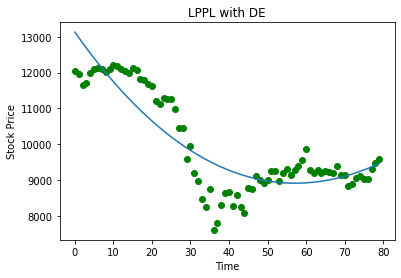

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

bound = [(1,1500),(-10,10),(600,650),(1,2),(-1,1),(0,2),(-1,1)] 
global Series
Series = [time, price]

def lppl (t,x):
    a = x[0]
    b = x[1]
    tc = x[2]
    m = x[3]
    c = x[4]
    w = x[5]
    phi = x[6]
    res=1;
    if abs(tc-t)>1:
        res=abs(tc-t);
    return a - (b*np.power(tc - t, m))*(1 + (c*np.cos((w *np.log(res))+phi)))  

def function(x):
    
    func = [lppl(t,x) for t in Series[0]]  
    func= np.subtract(func, Series[1])
    func = np.power(func, 2)
    return np.sum(func);

def getSeries(x):
    
    series = [lppl(t,x) for t in Series[0]]
    return series;

result = differential_evolution(function, bound)
plt.plot(Series[0], getSeries(result.x))
plt.scatter(Series[0], Series[1],color="green")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("LPPL with DE")
plt.show()

##4. Optimize the log-periodic power law (LPPL) parameters Evolutionary Programming (EP) for predicting stock price crisis.

##5.How COVID 19 pandemic impact on stock prices and find out correlation between COVID 19 and stock price and develop machine learning or statistical model for predict the same.

*   Here a linear model is used to find out the correlation between the stock price crisis and covid19 cases which are reported everyday. 
*   I haved used every covid19 cases against the closing stock price of NSE 




In [0]:
data.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),Covid
0,30-Jan-20,12147.75,12150.30,12010.60,12035.80,538138743,19372.67,1
1,31-Jan-20,12100.40,12103.55,11945.85,11962.10,771278258,26044.91,0
2,1-Feb-20,11939.00,12017.35,11633.30,11661.85,537634767,20598.12,0
3,3-Feb-20,11627.45,11749.85,11614.50,11707.90,669815788,25415.26,0
4,4-Feb-20,11786.25,11986.15,11783.40,11979.65,560430291,22338.5,1


* Let's plot and check the overall trend for the covid19 cases and the stock closing price over the period when covid19 started in India(from january 30 to May 29 is considered here)
* It can be clearly seen that as the number of covid19 cases are increasing the stock tends to fall



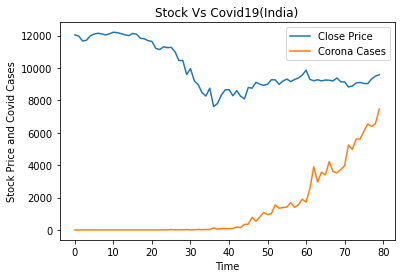

In [0]:
import matplotlib.pyplot as plt
X=data.index
Y1=data['Close']
Y2=data['Covid']
plt.xlabel('Time')
plt.ylabel('Stock Price and Covid Cases')
plt.title('Stock Vs Covid19(India)')
plt.plot(X,Y1)
plt.plot(X,Y2)
plt.legend(['Close Price','Corona Cases'])
plt.show()

* Let's Plot the covid cases with stock price and build a linear model for the same

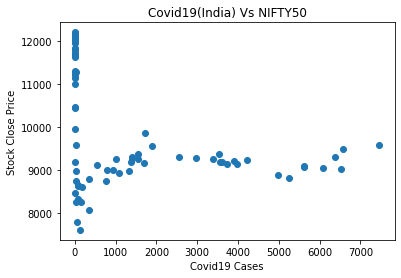

In [0]:
X=data['Covid']
Y=data['Close']
plt.xlabel('Covid19 Cases')
plt.ylabel('Stock Close Price')
plt.title('Covid19(India) Vs NIFTY50')
plt.scatter(X,Y)
plt.show()

* Here I have used sklearn.model_selection to split data into training and testing 
* The splitted data is build using the Linea Regression model from sklearn.model_selection


In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
X=data.Covid.values.reshape(-1,1)
y=data.Close.values.reshape(-1,1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15)

In [0]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()
LR.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

* The LR model build is fitted with the training data 
* The testing set is used to test and find out the correlation coefficients and the Mean Squared Error

In [0]:
prediction=LR.predict(X_test)

In [0]:
from sklearn.metrics import mean_squared_error,r2_score
print(f'Mean Squared Error:{mean_squared_error(y_test,prediction)}')

* The plot below shows the fit for the covid vs stock price
* From the plot it can be seen that it's not a perfect fit 
* The coefficeint of determination also says the same

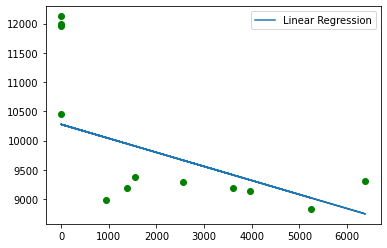

In [0]:
plt.scatter(X_test,y_test,color='green')
plt.plot(X_test,prediction,label='Linear Regression')
plt.legend()
plt.show()

In [0]:
print(f'Coefficients:{LR.coef_}')
print(f'Coefficient of determination:{r2_score(y_test,prediction)}')

Coefficients:[[-0.23972319]]
Coefficient of determination:0.3579065814217355




> Here I have build a Polynomial Regression model and tried with different degrees

> Here polynomial function of degree 2 is used to be build the model and further prediction



In [0]:
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
model = Pipeline([('poly',PolynomialFeatures(degree=2)),('Linear',LinearRegression())])
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('Linear',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [0]:
predict_poly=model.predict(X_test)

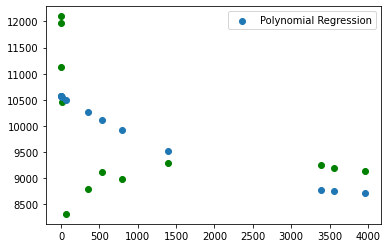

In [0]:
plt.scatter(X_test,y_test,color='green')
plt.scatter(X_test,predict_poly,label='Polynomial Regression')
plt.legend()
plt.show()

In [0]:
model.named_steps['Linear'].coef_

array([[ 0.00000000e+00, -9.09782269e-01,  1.12095845e-04]])

In [0]:
print(f'Mean Squared Error:{mean_squared_error(y_test,predict_poly)}')
print(f'Coefficient of determination:{r2_score(y_test,predict_poly)}')

Mean Squared Error:1170920.010085906
Coefficient of determination:0.21374304500554397


##6. How crude oil crisis impact on stock index and find out correlation between crude oil and stock index and develop machine learning or statistical model for predict the same.

* Here the same data as referred earlier will be used for stock price 
* The crude oil dataset is loaded in the pandas dataframe datacrud
* Here a linear model is used to find out the correlation between the stock price crisis and crude oil price which are reported everyday. 
* I haved used every day crude oil against the closing stock price of NIFTY50

In [0]:
import pandas as pd

datacrud.head()

,Instrument Type,Date,Segment,Commodity,Traded Contract(Lots),Total Value (Lacs),Avg Daily Turnover (Lacs),Unnamed: 7
0,FUTCOM,30-Jan-20,ENERGY,CRUDEOIL,403222,1512177.37,0.0,NaN
1,FUTCOM,31-Jan-20,ENERGY,CRUDEOIL,486278,1816467.07,0.0,NaN
2,FUTCOM,1-Feb-20,ENERGY,CRUDEOIL,20324,74741.67,0.0,NaN
3,FUTCOM,3-Feb-20,ENERGY,CRUDEOIL,566581,2076613.38,0.0,NaN
4,FUTCOM,4-Feb-20,ENERGY,CRUDEOIL,580187,2101216.42,0.0,NaN


In [0]:
del datacrud['Unnamed: 7']

In [0]:
datacrud.head()

,Instrument Type,Date,Segment,Commodity,Traded Contract(Lots),Total Value (Lacs),Avg Daily Turnover (Lacs)
0,FUTCOM,30-Jan-20,ENERGY,CRUDEOIL,403222,1512177.37,0.0
1,FUTCOM,31-Jan-20,ENERGY,CRUDEOIL,486278,1816467.07,0.0
2,FUTCOM,1-Feb-20,ENERGY,CRUDEOIL,20324,74741.67,0.0
3,FUTCOM,3-Feb-20,ENERGY,CRUDEOIL,566581,2076613.38,0.0
4,FUTCOM,4-Feb-20,ENERGY,CRUDEOIL,580187,2101216.42,0.0


* Let's plot and check the overall trend for the crude oil price and the stock closing price.
* It can be clearly seen that there is a correlation between the stock price and crude oil price.

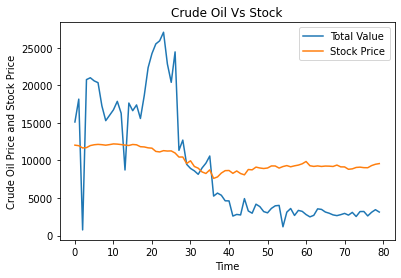

In [0]:
import matplotlib.pyplot as plt
X=datacrud.index
Y1=datacrud['Total Value (Lacs)']/100
Y2=data['Close']
plt.xlabel('Time')
plt.ylabel('Crude Oil Price and Stock Price')
plt.title('Crude Oil Vs Stock')
plt.plot(X,Y1)
plt.plot(X,Y2)
plt.legend(['Total Value','Stock Price'])
plt.show()

* Here I have plotted the stock price vs crude oil price 

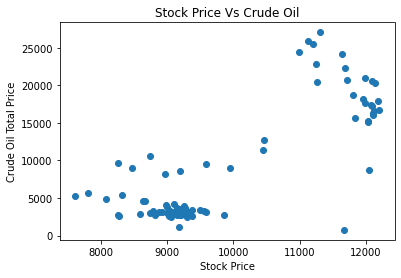

In [0]:
X=data['Close']
Y=datacrud['Total Value (Lacs)']/100
plt.xlabel('Stock Price')
plt.ylabel('Crude Oil Total Price')
plt.title('Stock Price Vs Crude Oil')
plt.scatter(X,Y)
plt.show()

* Here I have used sklearn.model_selection to split data into training and testing 
* The splitted data is build using the Linea Regression model from sklearn.model_selection

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
X=X.values.reshape(-1,1)
y=Y.values.reshape(-1,1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15)

* The LR model build is fitted with the training data 
* The testing set is used to test and find out the correlation coefficients and the Mean Squared Error

In [0]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()
LR.fit(X_train,y_train)
prediction=LR.predict(X_test)
from sklearn.metrics import mean_squared_error,r2_score
print(f'Mean Squared Error:{mean_squared_error(y_test,prediction)}')

Mean Squared Error:41192373.78461912


* Let's Plot the predicted model and see the results
* The coefficient of determination shows that the model is somewhat ok 

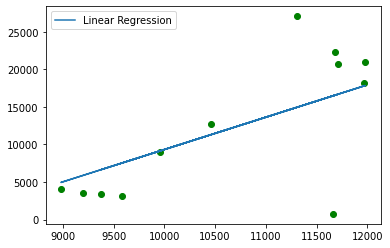

In [0]:
plt.scatter(X_test,y_test,color='green')
plt.plot(X_test,prediction,label='Linear Regression')
plt.legend()
plt.show()

In [0]:
print(f'Coefficients:{LR.coef_}')
print(f'Coefficient of determination:{r2_score(y_test,prediction)}')

Coefficients:[[4.3048857]]
Coefficient of determination:0.48336849657943526
